# Midterm: Evaluating the Impact of France's COVID-19 Reinforced Curfew

In late 2020, France implemented a nationwide curfew (6pm-6am) to combat the COVID-19 pandemic. Starting January 2nd, 2021, a "reinforced curfew" was progressively introduced in selected *departements* based on local epidemiological conditions:

- **January 2**: 15 departements (primarily eastern/mountainous regions)
- **January 10**: 8 additional departements
- **January 12**: 2 additional departements
- **January 16**: All remaining departements

This assignment evaluates different causal inference strategies for estimating the policy's effect on COVID-19 incidence rates.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
curfew_daily = pd.read_stata('../data/midterm/data_covid_daily.dta')
curfew_weekly = pd.read_stata('../data/midterm/data_covid_weekly.dta')

print(f'Daily data: {curfew_daily.shape}')
print(f'Columns: {list(curfew_daily.columns)}')
print(f'\nWeekly data: {curfew_weekly.shape}')
print(f'Columns: {list(curfew_weekly.columns)}')

Daily data: (7104, 5)
Columns: ['dep', 'day', 'n_positive', 'population', 'date_analysis']

Weekly data: (1056, 4)
Columns: ['dep', 'week', 'population', 'n_positive']


In [3]:
# Define treatment groups
jan2_deps = ['05', '06', '08', '25', '39', '51', '52', '54', '55', '57', '58', '70', '71', '88', '90']
jan10_deps = ['03', '04', '13', '18', '21', '67', '68', '84']
jan12_deps = ['26', '83']

---

## Question 1: Naive Cross-Sectional Comparison

Compare average incidence rates on January 15th between departements with the standard curfew and those with the reinforced curfew.

In [4]:
# Compute incidence rate
curfew_daily['incidence_rate'] = curfew_daily['n_positive'] / curfew_daily['population']

# Filter from Dec 15 onward (accounting for 5-day lag)
daily_filtered = curfew_daily[curfew_daily['date_analysis'] >= 22269].copy()

# Assign groups based on department and date (accounting for 5-day lag)
def assign_group(row):
    dep = row['dep']
    date = row['date_analysis']
    if dep in jan2_deps and date >= 22287:  # Jan 2 + 5 days
        return 'Reinforced Jan 2'
    elif dep in jan10_deps and date >= 22295:  # Jan 10 + 5
        return 'Reinforced Jan 10'
    elif dep in jan12_deps and date >= 22297:  # Jan 12 + 5
        return 'Reinforced Jan 12'
    elif date >= 22301:  # Jan 16 + 5
        return 'Reinforced Jan 16'
    else:
        return 'Standard Curfew'

daily_filtered['group'] = daily_filtered.apply(assign_group, axis=1)

# Group means
group_means = daily_filtered.groupby('group')['incidence_rate'].mean()
print('Average incidence rate by group:')
print(group_means.round(6))

Average incidence rate by group:
group
Reinforced Jan 10    0.000333
Reinforced Jan 12    0.000421
Reinforced Jan 16    0.000269
Reinforced Jan 2     0.000323
Standard Curfew      0.000238
Name: incidence_rate, dtype: float32


In [5]:
# T-tests: each reinforced group vs. standard
standard = daily_filtered.loc[daily_filtered['group'] == 'Standard Curfew', 'incidence_rate']

for group in ['Reinforced Jan 2', 'Reinforced Jan 10', 'Reinforced Jan 12', 'Reinforced Jan 16']:
    reinforced = daily_filtered.loc[daily_filtered['group'] == group, 'incidence_rate']
    if len(reinforced) > 0:
        t = stats.ttest_ind(reinforced, standard)
        print(f'{group:20s}: diff = {reinforced.mean() - standard.mean():.6f}, '
              f't = {t.statistic:.4f}, p = {t.pvalue:.4f}')

Reinforced Jan 2    : diff = 0.000085, t = 9.7829, p = 0.0000
Reinforced Jan 10   : diff = 0.000095, t = 7.0562, p = 0.0000
Reinforced Jan 12   : diff = 0.000183, t = 7.7772, p = 0.0000
Reinforced Jan 16   : diff = 0.000031, t = 6.1847, p = 0.0000


**Analysis**: The naive comparison shows higher incidence rates in reinforced curfew areas. However, this approach is flawed:

1. **Selection bias**: Departments received the reinforced curfew *because* they had higher infection rates. The treatment is endogenous.
2. **Unequal group sizes**: The control group contains ~96 departments while each treatment group has only a handful, leading to imprecise comparisons.
3. **No counterfactual**: Without knowing what would have happened absent the policy, we cannot attribute differences to the curfew itself.

---

## Question 2: Before-After Comparison

Compare incidence rates before and after the reinforced curfew among the January 2nd departements only.

In [6]:
# Filter to Jan 2 departments only
jan2_data = daily_filtered[daily_filtered['dep'].isin(jan2_deps)].copy()

before = jan2_data.loc[(jan2_data['date_analysis'] >= 22269) & (jan2_data['date_analysis'] < 22287), 'incidence_rate']
after = jan2_data.loc[(jan2_data['date_analysis'] >= 22287) & (jan2_data['date_analysis'] <= 22300), 'incidence_rate']

print(f'Mean incidence rate BEFORE (Dec 15 - Jan 1): {before.mean():.6f}')
print(f'Mean incidence rate AFTER  (Jan 2 - Jan 15): {after.mean():.6f}')

t_ba = stats.ttest_ind(before, after)
print(f'\nt-statistic: {t_ba.statistic:.4f}')
print(f'p-value:     {t_ba.pvalue:.4f}')

Mean incidence rate BEFORE (Dec 15 - Jan 1): 0.000371
Mean incidence rate AFTER  (Jan 2 - Jan 15): 0.000361

t-statistic: 0.4318
p-value:     0.6661


**Analysis**: This before-after comparison is also problematic:

1. **No control group**: Any change could be due to seasonal trends, other policies, or natural epidemic dynamics rather than the curfew.
2. **Geographic specificity**: The January 2nd group consists primarily of eastern/mountainous departments with distinct characteristics (lower population density, colder climate, proximity to European borders) that affect transmission independently.
3. **Not representative**: Results from this subset cannot be generalized to the entire country.

---

## Questions 3-4: Difference-in-Differences Strategy

We compare the evolution of incidence rates between:
- **Treatment group**: Departements receiving the reinforced curfew on January 2nd
- **Control group**: Departements receiving the reinforced curfew on January 16th (under standard curfew until then)

The treatment is binary: a departement either has the reinforced curfew or does not during the January 2-15 window.

**Econometric specification:**

$$Y_{it} = \beta_0 + \beta_1 \text{Treatment}_i + \beta_2 \text{Post}_t + \beta_3 (\text{Treatment}_i \times \text{Post}_t) + \varepsilon_{it}$$

- $H_0: \beta_3 = 0$ (no effect of reinforced curfew)
- $H_1: \beta_3 \neq 0$ (reinforced curfew affects incidence rates)

---

## Question 5a: Daily Incidence Rate Plot

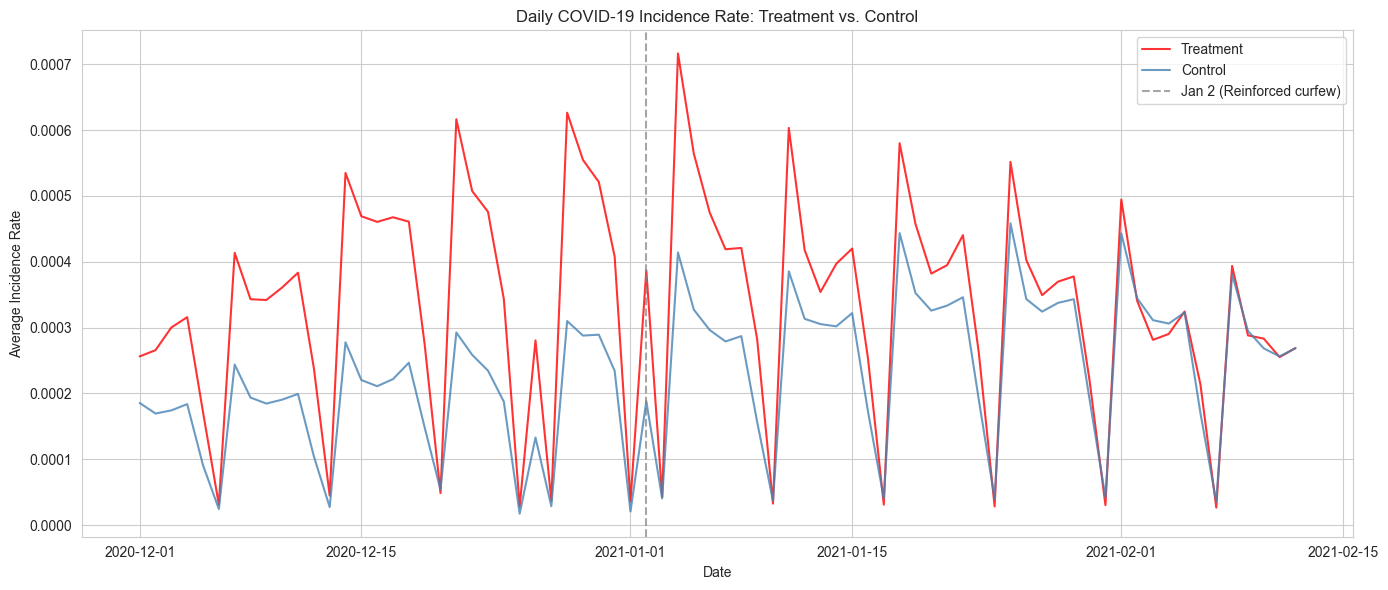

In [7]:
# Assign treatment/control for DiD
curfew_daily['group'] = curfew_daily['dep'].apply(
    lambda x: 'Treatment' if x in jan2_deps else 'Control'
)

# Filter Dec 1 to Feb 12
daily_did = curfew_daily[(curfew_daily['date_analysis'] >= 22250) & 
                         (curfew_daily['date_analysis'] <= 22323)].copy()
daily_did['incidence_rate'] = daily_did['n_positive'] / daily_did['population']

# Aggregate daily averages by group
daily_avg = daily_did.groupby(['date_analysis', 'group'])['incidence_rate'].mean().reset_index()
daily_avg['date'] = pd.to_datetime('2020-12-01') + pd.to_timedelta(daily_avg['date_analysis'] - 22250, unit='D')

fig, ax = plt.subplots(figsize=(14, 6))
for group, color in [('Treatment', 'red'), ('Control', 'steelblue')]:
    subset = daily_avg[daily_avg['group'] == group]
    ax.plot(subset['date'], subset['incidence_rate'], color=color, label=group, alpha=0.8)

ax.axvline(x=pd.Timestamp('2021-01-02'), color='gray', linestyle='--', alpha=0.7, label='Jan 2 (Reinforced curfew)')
ax.set_xlabel('Date')
ax.set_ylabel('Average Incidence Rate')
ax.set_title('Daily COVID-19 Incidence Rate: Treatment vs. Control')
ax.legend()
plt.tight_layout()
plt.show()

## Question 5b: Weekly Incidence Rate Plot

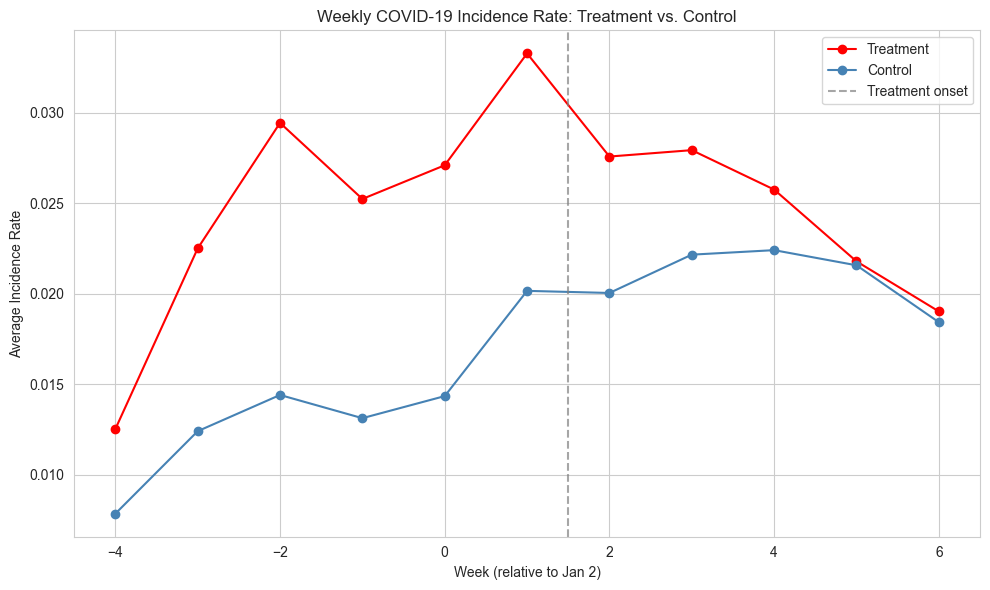

In [8]:
curfew_weekly['incidence_rate'] = curfew_weekly['n_positive'] / curfew_weekly['population']
curfew_weekly['group'] = curfew_weekly['dep'].apply(
    lambda x: 'Treatment' if x in jan2_deps else 'Control'
)

weekly_avg = curfew_weekly.groupby(['week', 'group'])['incidence_rate'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
for group, color in [('Treatment', 'red'), ('Control', 'steelblue')]:
    subset = weekly_avg[weekly_avg['group'] == group]
    ax.plot(subset['week'], subset['incidence_rate'], 'o-', color=color, label=group, markersize=6)

ax.axvline(x=1.5, color='gray', linestyle='--', alpha=0.7, label='Treatment onset')
ax.set_xlabel('Week (relative to Jan 2)')
ax.set_ylabel('Average Incidence Rate')
ax.set_title('Weekly COVID-19 Incidence Rate: Treatment vs. Control')
ax.legend()
plt.tight_layout()
plt.show()

## Question 5c: DiD Regression with Robust Standard Errors

In [9]:
curfew_weekly['treatment'] = curfew_weekly['dep'].isin(jan2_deps).astype(int)
curfew_weekly['post'] = (curfew_weekly['week'] >= 2).astype(int)

# DiD regression
did_model = smf.ols('incidence_rate ~ treatment * post', data=curfew_weekly).fit()
print('=== DiD Regression (Standard SE) ===')
print(did_model.summary().tables[1])

print()

# Robust standard errors (HC1)
did_robust = smf.ols('incidence_rate ~ treatment * post', data=curfew_weekly).fit(cov_type='HC1')
print('=== DiD Regression (Robust SE, HC1) ===')
print(did_robust.summary().tables[1])

=== DiD Regression (Standard SE) ===
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0137      0.000     43.505      0.000       0.013       0.014
treatment          0.0113      0.001     12.674      0.000       0.010       0.013
post               0.0072      0.000     15.417      0.000       0.006       0.008
treatment:post    -0.0078      0.001     -5.902      0.000      -0.010      -0.005

=== DiD Regression (Robust SE, HC1) ===
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0137      0.000     43.482      0.000       0.013       0.014
treatment          0.0113      0.001     11.531      0.000       0.009       0.013
post               0.0072      0.000     15.339      0.000       0.006       0.008
treatment

**Analysis**: The DiD estimate is statistically significant, suggesting the reinforced curfew reduced COVID-19 incidence rates in treated departements relative to control departements. 

The **parallel trends assumption** appears reasonable: before the treatment (weeks before January 2nd), both groups follow similar trajectories. After accounting for the lagged effect (~5 days), the treatment group's incidence rate begins converging toward the control group's rate, consistent with a treatment effect.

This contrasts with Questions 1 and 2, which failed to account for pre-existing differences between groups (Q1) or secular trends (Q2).

---

## Question 6: Regression Discontinuity Design

A classmate suggests using the distance to the border between departements as a running variable for an RDD.

**RDD identifying assumptions:**

1. **Continuity**: Potential outcomes are continuous at the cutoff. Villages on either side of a departement border likely share similar geographic, demographic, and economic characteristics, making this plausible.

2. **No manipulation**: Individuals cannot precisely manipulate their position relative to the cutoff. This largely holds since residential location is difficult to change quickly, though some people might temporarily relocate (e.g., staying with friends across the border).

**Concern**: Cross-border contamination is a threat. COVID-19 transmission is interpersonal, so individuals living near a border may interact with people on the other side, potentially violating the Stable Unit Treatment Value Assumption (SUTVA).

## Question 7: Internal Validity Threats

The RDD insight highlights potential threats to the DiD strategy:

- **Selection bias via geography**: Departments in different treatment waves are not randomly distributed across France. Bordered regions may share characteristics (climate, economic activity, cross-border mobility) that independently affect transmission.
- **Spillover effects**: If departments in the treatment group border control departments, behavioral responses (e.g., people from reinforced-curfew areas traveling to standard-curfew areas) could contaminate the control group, biasing the DiD estimate toward zero.

## Question 8: Ideal Experimental Design

The ideal approach would be a **Randomized Controlled Trial (RCT)**:

1. **Random assignment**: Randomly assign departements (or ideally individuals) to reinforced vs. standard curfew, stratifying by demographics, geography, and baseline infection rates.
2. **Identifying assumption**: Absent treatment, both groups would have similar outcomes on average (guaranteed by randomization).
3. **Blinding**: Ideally, individuals should not know which group they are in to avoid Hawthorne effects, though this is practically challenging for a public health intervention.
4. **Balance verification**: Conduct balance checks on observables to verify randomization worked.
5. **Estimation**: Compare mean incidence rates between treatment and control groups after allowing for an appropriate lag period.

**Practical challenges**: Ethical concerns about withholding a potentially beneficial intervention, compliance issues (people may not obey the curfew), and political feasibility of random assignment.